In [1]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from functions import *

2024-06-11 09:49:10.608882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 09:49:29.587661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/rds/general/user/yk222/home/anaconda3/envs/tf2_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_json('../Data/Target/dstc10-topical_eval.json')

#### make same context with same context ID
df_split = relevance_score(df)
df = df_split[["model", "context", "response", "overall_score"]]
df = df.sort_values(by=['context'])
id = list(range(1, 501)) * 9
id.sort()
df["context_id"] = id
df['context_response'] = df.apply(lambda x: f"{x['context']} [SEP] {x['response']}", axis=1)
df.head(10)

,model,context,response,overall_score,context_id,context_response
2823,t5,17 weeks if im not mistaken. then the playoffs...,<unk> s>I think it was a college game.,4.00,1,17 weeks if im not mistaken. then the playoffs...
2323,attention_s2s,17 weeks if im not mistaken. then the playoffs...,I think it was a college game and it was a col...,3.75,1,17 weeks if im not mistaken. then the playoffs...
1823,random,17 weeks if im not mistaken. then the playoffs...,I bet they do. They are probably made by engin...,3.00,1,17 weeks if im not mistaken. then the playoffs...
823,dialogpt,17 weeks if im not mistaken. then the playoffs...,"It was a pro game, but still. It was exciting ...",3.75,1,17 weeks if im not mistaken. then the playoffs...
3823,attention_vhred,17 weeks if im not mistaken. then the playoffs...,The coach was the coach and the coach was the ...,3.75,1,17 weeks if im not mistaken. then the playoffs...
3323,gpt3_davinci,17 weeks if im not mistaken. then the playoffs...,It is professional game. What is the highest s...,3.50,1,17 weeks if im not mistaken. then the playoffs...
323,blenderbot-400M-distill,17 weeks if im not mistaken. then the playoffs...,"I think it was a college game, but I'm not 100...",4.25,1,17 weeks if im not mistaken. then the playoffs...
4323,ground_truth,17 weeks if im not mistaken. then the playoffs...,222-0. It happened in 1916 when Georgia tech d...,4.50,1,17 weeks if im not mistaken. then the playoffs...
1323,attention_hred,17 weeks if im not mistaken. then the playoffs...,It was Georgia Tech beat Cumberland 222-0,3.50,1,17 weeks if im not mistaken. then the playoffs...
951,dialogpt,18 holes a games. Seems like a long day.\nYeah...,i agree. but is a popular sport that a lot of ...,3.75,2,18 holes a games. Seems like a long day.\nYeah...


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

2024-06-11 09:51:52.739102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22996 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:a1:00.0, compute capability: 7.5
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassificati

In [4]:
from tqdm import tqdm
def tokenizer_with_progress(large_batch):
    tokenized_texts = []
    for text in tqdm(large_batch, desc="Tokenizing", unit="text"):
        tokenized_texts.append(tokenizer(text, return_tensors="tf", padding='max_length', max_length=128, truncation=True))
    
    embeddings = []
    for input_text in tqdm(tokenized_texts, desc="Embedding", unit="text"):
        output = model(**input_text)
        word_embeddings = output.last_hidden_state
        embeddings.append(word_embeddings)

    return embeddings

In [ ]:
def kendall_tau(preds, train_data):
    y_true = train_data.get_label()
    tau, _ = kendalltau(y_true, preds)
    return 'kendall_tau', 50 * (1 + tau), True

### Cosine Similarity

In [170]:
context_embeddings = tokenizer_with_progress(df['context'].tolist())
response_embeddings = tokenizer_with_progress(df['response'].tolist())

Embedding: 100%|██████████| 4500/4500 [08:33<00:00,  8.76text/s]


In [171]:
context_sentence_embedding = [tf.reduce_mean(embed, axis=1) for embed in context_embeddings]
response_sentence_embedding = [tf.reduce_mean(embed, axis=1) for embed in response_embeddings]

In [175]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities = []
for i in range(len(df)):
    context_embedding_i = context_embeddings[i].numpy()  # Convert TensorFlow tensor to NumPy array
    response_embedding_i = response_embeddings[i].numpy()  # Convert TensorFlow tensor to NumPy array
    
    # Reshape the embeddings to 2D arrays
    context_embedding_i = context_embedding_i.reshape(1, -1)  # Reshape to a single row
    response_embedding_i = response_embedding_i.reshape(1, -1)  # Reshape to a single row
    
    # Calculate cosine similarity
    similarity = cosine_similarity(context_embedding_i, response_embedding_i)
    cosine_similarities.append(similarity[0, 0])  # Append the similarity value

print(np.mean(cosine_similarities))

0.39950728


In [177]:
tau, _ = kendalltau(cosine_similarities, np.round(df['overall_score']).astype(int).values)
print('kendall_tau', 50 * (1 + tau))

kendall_tau 53.92222595160611


In [202]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Combine context and response embeddings
combined_embeddings = []
for context_embed, response_embed in zip(context_embeddings, response_embeddings):
    combined_embed = np.concatenate([context_embed.numpy(), response_embed.numpy()], axis=0)
    combined_embeddings.append(combined_embed)

# Apply PCA to combined embeddings
combined_embeddings_pca = []
for combined_embed in combined_embeddings:
    combined_embed_2d = combined_embed.reshape(-1, combined_embed.shape[-1])  # Reshape to 2D array
    pca = PCA(n_components=48)  # Initialize PCA with desired number of components
    combined_embed_pca = pca.fit_transform(combined_embed_2d)  # Apply PCA
    combined_embed_pca = combined_embed_pca[:, 1:]
    combined_embeddings_pca.append(combined_embed_pca)

# Split combined embeddings back into context and response embeddings
context_embeddings_pca = [combined_embed_pca[:len(context_embed)] for combined_embed_pca, context_embed in zip(combined_embeddings_pca, context_embeddings)]
response_embeddings_pca = [combined_embed_pca[len(context_embed):] for combined_embed_pca, context_embed in zip(combined_embeddings_pca, context_embeddings)]

In [203]:
# Calculate cosine similarity
cosine_similarities = []
for i in range(len(df)):
    context_embedding_pca_i = context_embeddings_pca[i]  # PCA-transformed context embedding
    response_embedding_pca_i = response_embeddings_pca[i]  # PCA-transformed response embedding
    
    # Calculate cosine similarity
    similarity = cosine_similarity(context_embedding_pca_i, response_embedding_pca_i)
    cosine_similarities.append(similarity[0, 0])  # Append the similarity value

print("Mean cosine similarity after PCA:", np.mean(cosine_similarities))

Mean cosine similarity after PCA: 0.30730146


In [204]:
tau, _ = kendalltau(cosine_similarities, np.round(df['overall_score']).astype(int).values)
print('kendall_tau', 50 * (1 + tau))

kendall_tau 50.750110842217545


In [205]:
X = df[['overall_score','context_id']]
X['input'] = combined_embeddings_pca
X['similarity'] = cosine_similarities
X['overall_score'] = np.round(df['overall_score']).astype(int).values
context_id = df['context_id'].values

/var/tmp/pbs.9559646.pbs/ipykernel_3700769/3457754284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['input'] = combined_embeddings_pca
/var/tmp/pbs.9559646.pbs/ipykernel_3700769/3457754284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['similarity'] = cosine_similarities
/var/tmp/pbs.9559646.pbs/ipykernel_3700769/3457754284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [206]:
X_flattened = X.apply(lambda col: col['input'][0], axis=1).apply(pd.Series)
X = pd.concat([X_flattened, X[["context_id",'similarity', "overall_score"]]], axis=1)

In [207]:
from sklearn.model_selection import train_test_split
context_train, context_test = train_test_split(list(range(1, 501)), test_size=0.2, random_state=42)
train = X[X['context_id'].isin(context_train)]
test = X[X['context_id'].isin(context_test)]

X_train = train.drop(columns=["overall_score"])
y_train = train[["overall_score"]]

X_test = test.drop(columns=["overall_score"])
y_test = test[["overall_score"]]

group_train = np.bincount(context_train)[1:]
group_train = group_train*9
group_test = np.bincount(context_test)[1:]
group_test = group_test*9 

In [208]:
train_data = lgb.Dataset(X_train, label=y_train, group=group_train)
test_data = lgb.Dataset(X_test, label=y_test, group=group_test, reference=train_data)

# Define LightGBM parameters
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_at': [5],
    'learning_rate': 0.01,
    'boosting': 'gbdt',
    'verbose': 1
}


ranker = lgb.train(params, train_data, valid_sets=[train_data, test_data], 
                   num_boost_round=1000, feval=kendall_tau, callbacks=[lgb.log_evaluation(period=100)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12495
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 49
[100]	training's ndcg@5: 0.976359	training's kendall_tau: 74.1069	valid_1's ndcg@5: 0.955923	valid_1's kendall_tau: 51.3525
[200]	training's ndcg@5: 0.991932	training's kendall_tau: 78.1057	valid_1's ndcg@5: 0.955773	valid_1's kendall_tau: 52.1468
[300]	training's ndcg@5: 0.996205	training's kendall_tau: 79.8994	valid_1's ndcg@5: 0.955873	valid_1's kendall_tau: 52.3452
[400]	training's ndcg@5: 0.997889	training's kendall_tau: 80.9208	valid_1's ndcg@5: 0.956145	valid_1's kendall_tau: 52.5404
[500]	training's ndcg@5: 0.99888	training's kendall_tau: 81.5274	valid_1's ndcg@5: 0.956567	valid_1's kendall_tau: 52.6593
[600]	training's ndcg@5: 0.999409	training's kendall_tau: 82.014	valid_1's ndcg@5: 0.956944	

In [209]:
y_pred_train = ranker.predict(X_train)
y_pred_test = ranker.predict(X_test)

tau, _ = kendalltau(y_train, y_pred_train)
acc = 50 * (1 + tau)
print(acc)

tau, _ = kendalltau(y_test, y_pred_test)
acc = 50 * (1 + tau)
print(acc)

83.21809119899513
52.67197666191091


In [210]:
df.reset_index(drop=True, inplace=True)
acc_list = []
for id in context_test:
    test_subset = test[test['context_id'] == id]
    X_subset = test_subset.drop(columns=["overall_score"])
    y_subset = test_subset[["overall_score"]]

    y_pred_subset = ranker.predict(X_subset)

    # Calculate accuracy using Kendall's Tau
    tau, _ = kendalltau(y_subset, y_pred_subset)
    acc = 50 * (1 + tau)
    acc_list.append(acc)

In [212]:
np.nanmean(acc_list)

53.09149901666611

### Tokenizer and word emnedding (combine the context and response)

In [5]:
context_response_embeddings = tokenizer_with_progress(df['context_response'].tolist())
bert_features = [tf.reduce_mean(embed, axis=1) for embed in context_response_embeddings]

Embedding: 100%|██████████| 4500/4500 [08:46<00:00,  8.55text/s]


In [7]:
# text_data = df['context_response'].tolist()
y = np.round(df['overall_score']).astype(int).values
context_id = df['context_id'].values

In [23]:
bert_features_2d = np.array(bert_features).reshape(4500, 768)
columns = [f'col{i+1}' for i in range(bert_features_2d.shape[1])]
X = pd.DataFrame(bert_features_2d, columns=columns)
X['overall_score'] = y
X['context_id'] = context_id

#### Control for fix effect (ignore first)

In [ ]:
import statsmodels.api as sm
from patsy import dmatrices

cols_to_include = [col for col in X.columns if col.startswith('col')]
formula = ' + '.join(cols_to_include)
formula = 'overall_score ~ C(context_id) + ' + formula

# Fit a fixed-effects model with train_id as a fixed effect
model = sm.OLS.from_formula(formula, data=X)
result = model.fit()

# Print the summary of the model
# print(result.summary())

In [41]:
fixed_effect = result.params.filter(like='C(context_id)')
fixed_effect = fixed_effect.to_list()
# print(len(fixed_effect))
fixed_effect = [0] + fixed_effect
fixed_effect = [effect for effect in fixed_effect for _ in range(9)]
# print(len(fixed_effect))
X['fixed_effect'] = fixed_effect
X['adjust_score'] = X['fixed_effect'] + X['overall_score']

In [55]:
X['adjust_score'] = np.round(X['adjust_score']).astype(int).values
min_num = X['adjust_score'].min()
if min_num < 0:
    X['adjust_score'] = X['adjust_score'] - min_num

### Ranking

In [24]:
from sklearn.model_selection import train_test_split
context_train, context_test = train_test_split(list(range(1, 501)), test_size=0.2, random_state=42)
train = X[X['context_id'].isin(context_train)]
test = X[X['context_id'].isin(context_test)]

X_train = train.drop(columns=["overall_score"])
y_train = train[["overall_score"]]

X_test = test.drop(columns=["overall_score"])
y_test = test[["overall_score"]]

group_train = np.bincount(context_train)[1:]
group_train = group_train*9 
group_test = np.bincount(context_test)[1:]
group_test = group_test*9 

In [30]:
train_data = lgb.Dataset(X_train, label=y_train, group=group_train)
test_data = lgb.Dataset(X_test, label=y_test, group=group_test, reference=train_data)

def kendall_tau(preds, train_data):
    y_true = train_data.get_label()
    tau, _ = kendalltau(y_true, preds)
    return 'kendall_tau', 50 * (1 + tau), True


# Define LightGBM parameters
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_at': [5],
    'learning_rate': 0.01,
    'boosting': 'gbdt',
    'verbose': 1
}


ranker = lgb.train(params, train_data, valid_sets=[train_data, test_data], 
                   num_boost_round=3000, feval=kendall_tau, callbacks=[lgb.log_evaluation(period=500)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196095
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 769
[500]	training's ndcg@5: 0.998863	training's kendall_tau: 83.099	valid_1's ndcg@5: 0.969937	valid_1's kendall_tau: 57.851
[1000]	training's ndcg@5: 0.999106	training's kendall_tau: 84.2861	valid_1's ndcg@5: 0.971165	valid_1's kendall_tau: 58.5987
[1500]	training's ndcg@5: 0.999106	training's kendall_tau: 84.8325	valid_1's ndcg@5: 0.971834	valid_1's kendall_tau: 58.9596
[2000]	training's ndcg@5: 0.999106	training's kendall_tau: 85.1606	valid_1's ndcg@5: 0.970895	valid_1's kendall_tau: 59.0775
[2500]	training's ndcg@5: 0.999106	training's kendall_tau: 85.4071	valid_1's ndcg@5: 0.971863	valid_1's kendall_tau: 59.2136
[3000]	training's ndcg@5: 0.999106	training's kendall_tau: 85.5807	valid_1's ndcg@5: 0.

In [31]:
y_pred_train = ranker.predict(X_train)
y_pred_test = ranker.predict(X_test)

tau, _ = kendalltau(y_train, y_pred_train)
acc = 50 * (1 + tau)
print(acc)

tau, _ = kendalltau(y_test, y_pred_test)
acc = 50 * (1 + tau)
print(acc)

85.58066027077025
59.263605696977265


In [32]:
df.reset_index(drop=True, inplace=True)
acc_list = []
for id in context_test:
    test_subset = test[test['context_id'] == id]
    X_subset = test_subset.drop(columns=["overall_score"])
    y_subset = test_subset[["overall_score"]]

    y_pred_subset = ranker.predict(X_subset)

    # Calculate accuracy using Kendall's Tau
    tau, _ = kendalltau(y_subset, y_pred_subset)
    acc = 50 * (1 + tau)
    acc_list.append(acc)

In [33]:
np.nanmean(acc_list)

63.87148979822759

### PCA

In [59]:
from sklearn.model_selection import train_test_split
context_train, context_test = train_test_split(list(range(1, 501)), test_size=0.2, random_state=42)
train = X[X['context_id'].isin(context_train)]
test = X[X['context_id'].isin(context_test)]

train.rename(columns={col: str(col) for col in train.columns}, inplace=True)
test.rename(columns={col: str(col) for col in test.columns}, inplace=True)


X_train = train.drop(columns=["overall_score"])
y_train = train[["overall_score"]]

X_test = test.drop(columns=["overall_score"])
y_test = test[["overall_score"]]

group_train = np.bincount(context_train)[1:]
group_train = group_train*9 
group_test = np.bincount(context_test)[1:]
group_test = group_test*9 

/var/tmp/pbs.9560567.pbs/ipykernel_4138335/179227380.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={col: str(col) for col in train.columns}, inplace=True)
/var/tmp/pbs.9560567.pbs/ipykernel_4138335/179227380.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.rename(columns={col: str(col) for col in test.columns}, inplace=True)


In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the feature columns separately for the training and testing sets
scaler = StandardScaler()
X_train_scaled = X_train.drop(columns=["context_id"])
X_test_scaled = X_test.drop(columns=["context_id"])
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

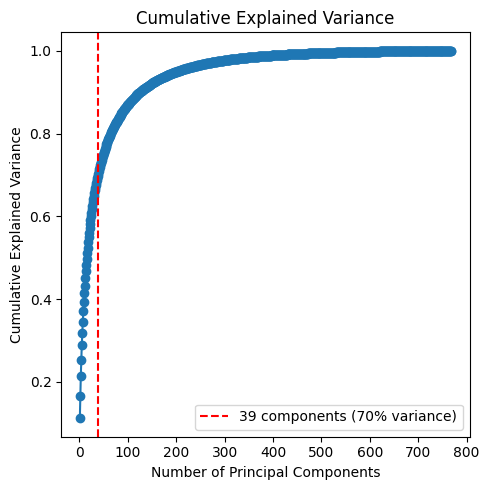

Number of components explaining 70% variance: 39


In [62]:
# Check how many PCA can explain 80% of the data
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Find the number of components
n_components_70 = np.argmax(cumulative_explained_variance >= 0.7) + 1

# Plot 
plt.figure(figsize=(5, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.axvline(x=n_components_70, color='r', linestyle='--', label=f'{n_components_70} components (70% variance)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Number of components explaining 70% variance: {n_components_70}")

In [63]:
# Apply PCA only to the standardized feature columns
pca = PCA(n_components=39)  # Adjust the number of components as needed
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_scaled))
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled))

X_train.reset_index(drop=True, inplace=True)
X_train_pca = pd.concat([X_train_pca, X_train['context_id']], axis=1)

X_test.reset_index(drop=True, inplace=True)
X_test_pca = pd.concat([X_test_pca, X_test['context_id']], axis=1)

In [65]:
X_train_pca_dropped = X_train_pca.drop(X_train_pca.columns[0], axis=1)
X_test_pca_dropped = X_test_pca.drop(X_test_pca.columns[0], axis=1)

In [ ]:
x_train_data = X_train_pca_dropped
x_test_data = X_test_pca_dropped


train_data = lgb.Dataset(x_train_data, label=y_train, group=group_train)
test_data = lgb.Dataset(x_test_data, label=y_test, group=group_test, reference=train_data)

def kendall_tau(preds, train_data):
    y_true = train_data.get_label()
    tau, _ = kendalltau(y_true, preds)
    return 'kendall_tau', 50 * (1 + tau), True

# Define LightGBM parameters
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_at': [5],
    'learning_rate': 0.01,
    'boosting': 'gbdt',
    'lambda_l1': 0.3, 
    'lambda_l2': 0.1, 
    'verbose': 1
}

ranker = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=3000, feval=kendall_tau, callbacks=[lgb.log_evaluation(period=500)])

In [67]:
y_pred_train = ranker.predict(x_train_data)
y_pred_test = ranker.predict(x_test_data)

tau, _ = kendalltau(y_train, y_pred_train)
acc = 50 * (1 + tau)
print(acc)

tau, _ = kendalltau(y_test, y_pred_test)
acc = 50 * (1 + tau)
print(acc)

80.17971834631001
56.72362930980446


In [ ]:
df.reset_index(drop=True, inplace=True)
acc_list = []
for id in context_test:
    test_subset = test[test['context_id'] == id]
    X_subset = test_subset.drop(columns=["overall_score", "context_id"])
    X_subset_scaled = scaler.transform(X_subset)    
    X_subset_pca = pca.transform(X_subset_scaled)
    X_subset_pca = pd.DataFrame(X_subset_pca)
    X_subset_pca["context_id"] = [id]*len(X_subset_pca)
    X_subset_pca_dropped = X_subset_pca.drop(columns=[0])
    y_subset = test_subset[["overall_score"]]

    y_pred_subset = ranker.predict(X_subset_pca_dropped)
   
    # Calculate accuracy using Kendall's Tau
    tau, _ = kendalltau(y_subset, y_pred_subset)
    acc = 50 * (1 + tau)
    acc_list.append(acc)

In [81]:
np.nanmean(acc_list)

61.24865752363682

### Imput as a vector

In [82]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [95]:
data_grouped = df.groupby('context_id').agg({
    'context_response': list, 
    'overall_score': list
}).reset_index()
data_grouped.head()

,context_id,context_response,overall_score
0,1,[17 weeks if im not mistaken. then the playoff...,"[4.0, 3.75, 3.0, 3.75, 3.75, 3.5, 4.25, 4.5, 3.5]"
1,2,[18 holes a games. Seems like a long day.\nYea...,"[3.75, 4.25, 4.0, 4.5, 3.5, 4.25, 3.0, 2.5, 3.75]"
2,3,[222-0. I dont even see how that is possible. ...,"[3.0, 4.5, 2.5, 1.25, 4.5, 1.5, 1.0, 4.75, 3.25]"
3,4,[300 of them? that sounds impressive and too b...,"[3.25, 4.25, 3.75, 4.0, 3.5, 4.5, 2.75, 3.75, ..."
4,5,[A Mars colonization project planned for 2023 ...,"[3.5, 4.0, 4.5, 4.0, 3.0, 3.75, 2.25, 4.0, 2.75]"


In [102]:
class RankingModel(tf.keras.Model):
    def __init__(self, num_outputs, bert_trainable=False):
        super(RankingModel, self).__init__()
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')
        self.bert.trainable = bert_trainable
        self.dense = Dense(num_outputs, activation='linear')

    def call(self, inputs):
        bert_output = self.bert(inputs)[0][:, 0, :]
        output = self.dense(bert_output)
        return output

def custom_loss(true_labels, output):
    return 1 - tf.reduce_mean(tf.keras.losses.cosine_similarity(true_labels, output))

def train_model(data, true_labels, epochs, lr, bert_trainable=False):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = RankingModel(num_outputs=1, bert_trainable=bert_trainable)
    optimizer = Adam(lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for i in tqdm(range(len(data)), desc=f'Epoch {epoch+1}/{epochs}', unit='batch'):
            with tf.GradientTape() as tape:
                input_ids = []
                for sentence in data[i]:
                    encoded = tokenizer.encode(
                        sentence,
                        add_special_tokens=True,
                        max_length=128,
                        truncation=True,
                        padding='max_length',
                        return_tensors='tf'
                    )
                    input_ids.append(encoded)
                input_ids = tf.concat(input_ids, axis=0)
                labels = tf.constant([true_labels[i]], dtype=tf.float32)
                outputs = model(input_ids)
                loss = custom_loss(labels, outputs)
                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                total_loss += loss

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(data)}")

    return model

def predict_scores(model, data):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    predictions = []

    for i in range(len(data)):
        input_ids = []
        for sentence in data[i]:
            encoded = tokenizer.encode(
                sentence,
                add_special_tokens=True,
                max_length=128,
                truncation=True,
                padding='max_length',
                return_tensors='tf'
            )
            input_ids.append(encoded)
        input_ids = tf.concat(input_ids, axis=0)
        outputs = model(input_ids)
        predictions.append(outputs.numpy().flatten())

    return predictions

def calculate_kendall_tau(true_labels, predicted_scores):
    tau_list = []

    for true, pred in zip(true_labels, predicted_scores):
        tau, _ = kendalltau(true, pred)
        tau_list.append(50*(1+tau))

    return tau_list

In [ ]:
data = data_grouped["context_response"].tolist()
true_labels = data_grouped["overall_score"].tolist()

#### For test
data = data[:100]
true_labels = true_labels[:100]
data_train, data_test, labels_train, labels_test = train_test_split(data, true_labels, test_size=0.2, random_state=42)

# Train the model
model = train_model(data_train, labels_train, epochs=3, lr=0.01, bert_trainable=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/5, Loss: -1.9418901205062866


Epoch 2/5: 100%|██████████| 80/80 [00:23<00:00,  3.47batch/s]


Epoch 2/5, Loss: -1.9584420919418335


Epoch 3/5: 100%|██████████| 80/80 [00:23<00:00,  3.47batch/s]


Epoch 3/5, Loss: -1.9584420919418335


Epoch 4/5:  79%|███████▉  | 63/80 [00:18<00:04,  3.48batch/s]

In [109]:
# Predict scores using the trained model
predicted_scores = predict_scores(model, data_test)
kendall_tau = calculate_kendall_tau(labels_test, predicted_scores)
print("Kendall's Tau:", kendall_tau)

Kendall's Tau: [39.84547006925096, 60.476975951561876, 42.26269424262284, 46.549672203288225, 75.72478777137633, 32.85014148574912, 38.21488698022421, 31.666666666666664, 63.055824196677335, 55.89255650988789, 70.00816826662603, 48.503289149776876, 42.74676433517926, 36.0728496367211, 21.56249384576064, 60.154529930749035, 39.84547006925096, 44.28338049524971, 48.54935286703585, 70.00816826662603]


In [110]:
np.mean(kendall_tau)

48.41370714701405